# 🔍 SEO Keyword-Analyse & Web-Crawler

Willkommen zum interaktiven SEO-Analyse Tool. Dieses Notebook führt Sie Schritt für Schritt durch den Prozess der Keyword-Extraktion von einer Webseite.

### Der Ablauf:
1. **Daten-Extraktion:** Wir laden den Inhalt einer URL.
2. **Strukturanalyse:** Untersuchung der HTML-Elemente (H1, H2, Titel).
3. **Text-Bereinigung:** Entfernen von Stoppwörtern und Sonderzeichen.
4. **Relevanz-Analyse:** Gewichtung der Wörter basierend auf SEO-Kriterien.
5. **Phrasen-Extraktion:** Finden von Long-Tail Keywords.

## 🛠 Phase 1: Vorbereitung
Zuerst laden wir die notwendigen Bibliotheken für Web-Scraping, Datenverarbeitung und Visualisierung.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake
import nltk
from collections import Counter
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

# NLTK Daten herunterladen (für Textanalyse)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords

# Design-Einstellungen für Grafiken
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print("✅ Bibliotheken erfolgreich geladen.")

✅ Bibliotheken erfolgreich geladen.


## 🌐 Phase 2: URL Eingabe
Geben Sie hier die URL der Webseite ein, die Sie analysieren möchten.

In [2]:
url_widget = widgets.Text(
    value='https://www.chefkoch.de/rezepte/1492481254305452/feuervogels-Brauhaus-Burger.html',
    placeholder='https://...',
    description='<b>URL:</b>',
    layout=widgets.Layout(width='70%')
)

lang_widget = widgets.Dropdown(
    options=[('Deutsch', 'german'), ('Englisch', 'english')],
    value='german',
    description='<b>Sprache:</b>',
)

display(widgets.VBox([url_widget, lang_widget]))

## 🎣 Phase 3: Daten-Extraktion (Scraping)
In diesem Schritt laden wir den HTML-Code der Seite und extrahieren die wichtigsten SEO-Elemente.

/var/folders/fq/cnfl852x0jldb_jt0yzh2svr0000gn/T/ipykernel_93858/2834946840.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Anzahl', y='Element', data=plot_df, palette="Blues_d", ax=ax)


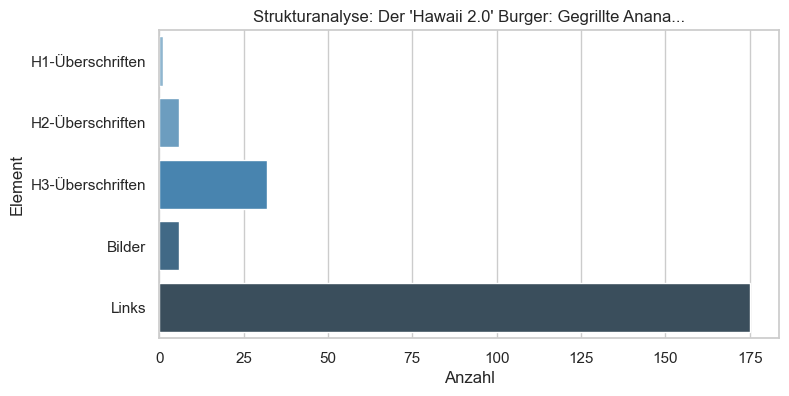

**Gefundener Seitentitel:** Der 'Hawaii 2.0' Burger: Gegrillte Ananas, Teriyaki-Glasur und knuspriger Schinken - Mein Store

In [7]:
def fetch_data(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/91.0.4472.124'}
    try:
        resp = requests.get(url, headers=headers, timeout=10)
        resp.raise_for_status()
        return BeautifulSoup(resp.text, 'html.parser')
    except Exception as e:
        print(f"❌ Fehler beim Laden: {e}")
        return None

soup = fetch_data(url_widget.value)

if soup:
    # Daten extrahieren
    page_data = {
        'Titel': soup.title.string if soup.title else 'N/A',
        'H1-Überschriften': len(soup.find_all('h1')),
        'H2-Überschriften': len(soup.find_all('h2')),
        'H3-Überschriften': len(soup.find_all('h3')),
        'Bilder': len(soup.find_all('img')),
        'Links': len(soup.find_all('a'))
    }
    
    # Visualisierung der Struktur
    structure_df = pd.DataFrame(list(page_data.items()), columns=['Element', 'Anzahl'])
    # Nur die numerischen Werte für den Plot nutzen
    plot_df = structure_df[structure_df['Element'] != 'Titel']
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x='Anzahl', y='Element', data=plot_df, palette="Blues_d", ax=ax)
    plt.title(f"Strukturanalyse: {page_data['Titel'][:40]}...")
    plt.show()
    
    display(Markdown(f"**Gefundener Seitentitel:** {page_data['Titel']}"))

## 🧹 Phase 4: Textbereinigung
Rohdaten enthalten viele unnötige Wörter (Stoppwörter wie "und", "der", "die"). Wir bereinigen den Text, um uns auf die echten Keywords zu konzentrieren.

/var/folders/fq/cnfl852x0jldb_jt0yzh2svr0000gn/T/ipykernel_93858/1117449991.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Status', y='Anzahl', data=counts, palette="Greens_d")


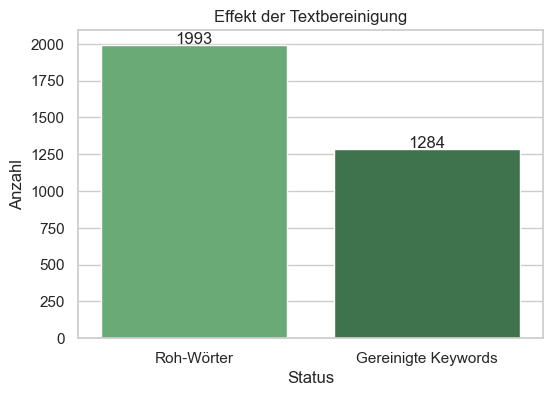

Reduktion um 35.6% durch Stoppwort-Filter.


In [8]:
def get_clean_text(soup, lang):
    # Skripte und Styles entfernen
    for s in soup(["script", "style"]):
        s.decompose()
        
    text = soup.get_text(separator=' ', strip=True).lower()
    words_raw = re.findall(r'[a-zäöüß]+', text)
    
    stop_words = set(stopwords.words(lang))
    words_cleaned = [w for w in words_raw if w not in stop_words and len(w) > 2]
    
    return words_raw, words_cleaned

raw_w, clean_w = get_clean_text(soup, lang_widget.value)

# Visualisierung des Effekts
counts = pd.DataFrame({
    'Status': ['Roh-Wörter', 'Gereinigte Keywords'],
    'Anzahl': [len(raw_w), len(clean_w)]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Status', y='Anzahl', data=counts, palette="Greens_d")
plt.title("Effekt der Textbereinigung")
for i, v in enumerate(counts['Anzahl']):
    plt.text(i, v + 10, str(v), ha='center')
plt.show()

print(f"Reduktion um {100 - (len(clean_w)/len(raw_w)*100):.1f}% durch Stoppwort-Filter.")

## 🚀 Phase 5: Keyword-Ranking (SEO-Gewichtung)
Nicht jedes Wort ist gleich wichtig. Wörter im **Titel** oder in **H1-Überschriften** zählen bei Google & Co. mehr. Wir berechnen einen Score basierend auf der Häufigkeit und der Position.

/var/folders/fq/cnfl852x0jldb_jt0yzh2svr0000gn/T/ipykernel_93858/1357022711.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SEO-Score', y='Keyword', data=df_final, palette="rocket")


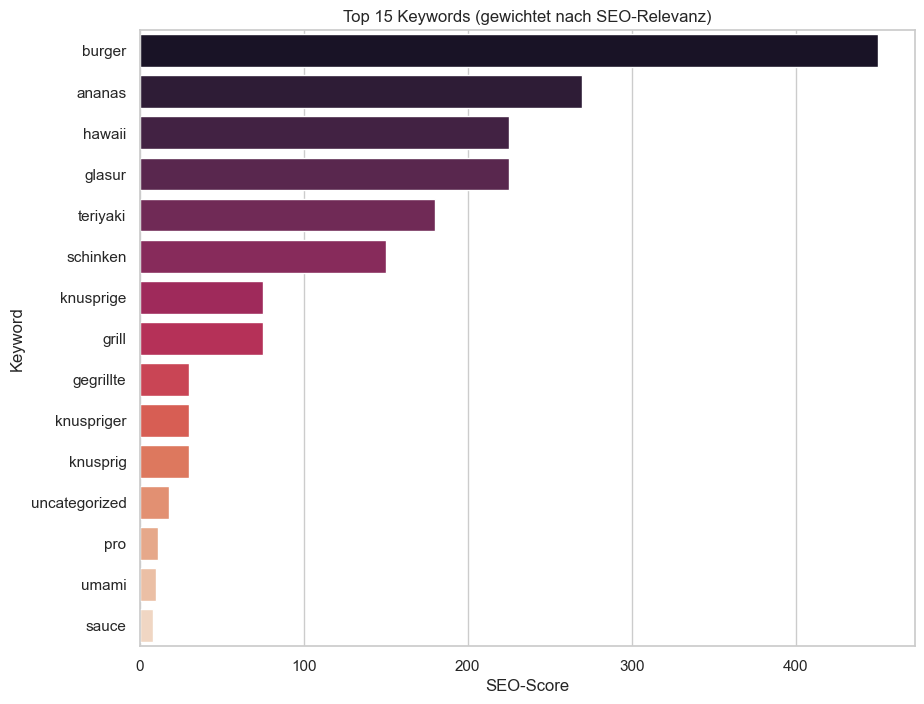

In [9]:
def calculate_seo_scores(soup, clean_words, lang):
    # Basis: Häufigkeit
    counts = Counter(clean_words)
    
    # SEO Boost-Zonen
    title_text = soup.title.string.lower() if soup.title else ""
    h1_text = " ".join([h.get_text().lower() for h in soup.find_all('h1')])
    
    scores = {}
    for word, count in counts.items():
        score = count * 1.0
        if word in title_text: score *= 5.0  # Titel ist extrem wichtig
        if word in h1_text: score *= 3.0     # H1 ist sehr wichtig
        scores[word] = score
        
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:15]

top_keywords = calculate_seo_scores(soup, clean_w, lang_widget.value)
df_final = pd.DataFrame(top_keywords, columns=['Keyword', 'SEO-Score'])

plt.figure(figsize=(10, 8))
sns.barplot(x='SEO-Score', y='Keyword', data=df_final, palette="rocket")
plt.title("Top 15 Keywords (gewichtet nach SEO-Relevanz)")
plt.show()

## 🧠 Phase 6: Long-Tail Phrasen (RAKE)
Oft suchen Nutzer nicht nach einzelnen Wörtern, sondern nach Phrasen (z.B. "Brauhaus Burger Rezept"). Hier nutzen wir den RAKE-Algorithmus (Rapid Automatic Keyword Extraction).

In [10]:
r = Rake(language=lang_widget.value)
full_text = soup.get_text()
r.extract_keywords_from_text(full_text)
phrases = r.get_ranked_phrases_with_scores()[:10]

print("💡 Empfohlene Long-Tail Keywords:")
for score, phrase in phrases:
    if len(phrase.split()) > 1: # Nur echte Phrasen anzeigen
        print(f"• {phrase.title()} (Relevanz: {score:.1f})")

💡 Empfohlene Long-Tail Keywords:
• Adresse Suche Gourmet Pro Gourmet Pro Gourmet Pro Home Cookbook Lifestyle Recipe Inspiration Health Beauty More Dessert Salad Fish Chicken Steak Type Here ... Suche Facebookinstagramvkontakteyoutube Gourmet Pro Home Cookbook Lifestyle Recipe Inspiration Health Beauty More Dessert Salad Fish Chicken Steak Type Here ... Suche Facebookinstagramvkontakteyoutube Uncategorized (Relevanz: 1602.5)
• Store Facebook Instagram Vkontakte Youtube Anmelden Home Cookbook Lifestyle Recipe Inspiration Health Beauty More Dessert Salad Fish Chicken Steak Anmelden Herzlich Willkommen (Relevanz: 643.9)
• Gourmet Pro With Chef Rachael Home Cookbook Lifestyle Recipe Inspiration Health Beauty More (Relevanz: 342.0)
• Nährstoff Geschätzter Wert Kalorien 950 Kcal Protein 46 G Fett 58 G Kohlenhydrate 54 G (Relevanz: 201.5)
• United Kingdom Subscribe To Our Newsletterlatest Healthy And Delicious Recipessubscribedelivered Directly (Relevanz: 121.0)
• Gourmet Pro Facebookinstagram